House price example from VMLS Section 13.2

In [1]:
import numpy as np
from numpy.linalg import cholesky as llt
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})
np.random.seed(100)  # To reproduce same random numbers

In [2]:
def forward_substitution(L, b):
    n = L.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - L[i,:i] @ x[:i])/L[i, i]
    return x

def backward_substitution(U, b):
    n = U.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (b[i] - U[i,i+1:] @ x[i+1:])/U[i, i]
    return x

def lstsq(A, b):
    M = A.T.dot(A)
    q = A.T.dot(b)
    L = llt(M)
    x = forward_substitution(L, q)
    x = backward_substitution(L.T, x)
    return x, L

In [3]:
# Load house price data
# 774 House sales in Sacramento area.
# Column 1: region (1--4) based on 5-digit ZIP code (see Table 13.4.)
# Column 2: number of bedrooms.
# Column 3: number of bathrooms.
# Column 4: house area in square feet.
# Column 5: 1 if a condo, 0 otherwise.
# Column 6: selling price in thousand dollars.
data = pd.read_csv('house_price.csv')
data

,price,area,beds,baths,condo,location
0,94.905,0.941,2,2,1,2
1,98.937,1.146,3,2,0,2
2,100.309,0.909,3,2,0,2
3,106.250,1.289,3,2,0,3
4,107.502,1.020,3,1,0,3
...,...,...,...,...,...,...
769,232.425,2.280,4,3,0,3
770,234.000,1.477,3,2,0,3
771,235.000,1.216,3,2,0,2
772,235.301,1.685,4,2,0,3


In [4]:
price = data['price'] 
area = data['area']
beds = data['beds']
condo = data['condo']
location = data['location']
N = len(price)
X = np.column_stack([np.ones(N), area, np.maximum(area - 1.5, 0), beds, condo, location==2, location==3, location==4]) 
theta = lstsq(X, price)[0]
theta

array([ 115.61682367,  175.41314064,  -42.74776797,  -17.87835524,
        -19.04472565, -100.91050309, -108.79112222,  -24.76524735])

In [28]:
# Relative prediction error
np.linalg.norm(X @ theta - price)/np.linalg.norm(price)

0.26873225112365395

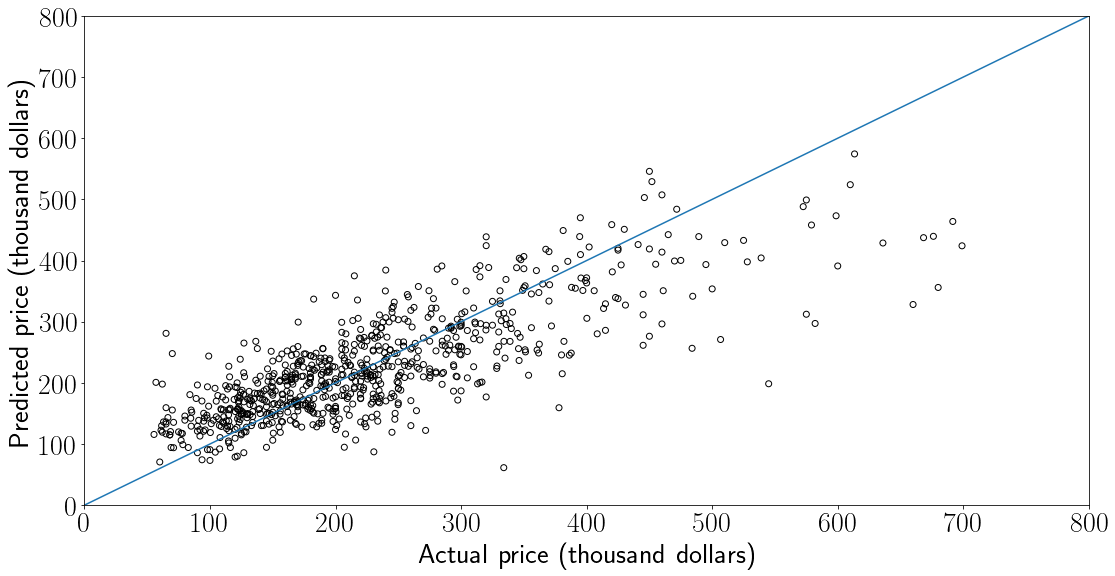

In [29]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.scatter(price, X @ theta,  marker='o', color='k', facecolors='none') 
plt.plot([0, 800], [0, 800]) 
plt.ylim(0,800)
plt.xlim(0,800) 
plt.xlabel('Actual price (thousand dollars)') 
plt.ylabel('Predicted price (thousand dollars)')
plt.savefig('house_price.pdf')

In [30]:
I = np.array_split(np.random.permutation(N), 5)  # Get index of samples in each fold

# Store results in pandas dataframe
# We will build it using a list where each
# element is a dictionary of each row
results = []

for k in range(5):
    I_train = list(I)
    I_test = I_train.pop(k)  # Remove folds k
    I_train = np.concatenate(I_train)
    N_train, N_test = len(I_train), len(I_test)
    theta = lstsq(X[I_train], price[I_train])[0] 
    
    d = {'Fold': k + 1,  # k+1 because it starts from 0
         'Train error': np.linalg.norm(X[I_train] @ theta - price[I_train])/np.linalg.norm(price[I_train]),
         'Test error': np.linalg.norm(X[I_test] @ theta - price[I_test])/np.linalg.norm(price[I_test])
        }
    
    # Add to d the elements of the parameter theta
    d.update({r'$\theta_%d$' % (s+1):theta[s] for s in range(len(theta))})
    
    # Concatenate another row of the results
    results.append(d)

results_data = pd.DataFrame(results)
results_data

,Fold,Train error,Test error,$\theta_1$,$\theta_2$,$\theta_3$,$\theta_4$,$\theta_5$,$\theta_6$,$\theta_7$,$\theta_8$
0,1,0.261713,0.299463,115.600942,177.528473,-47.049984,-14.642813,-13.901869,-111.999593,-122.586011,-36.507374
1,2,0.262923,0.288638,121.591999,165.484085,-30.353843,-17.742118,-20.209549,-95.217506,-103.672643,-7.939687
2,3,0.273452,0.246214,117.826270,181.178593,-49.777480,-19.296263,-18.676968,-106.503392,-112.760848,-32.373844
3,4,0.272444,0.252834,103.996658,174.540880,-41.958853,-18.805151,-17.130135,-85.676735,-92.090595,-6.986945
4,5,0.268043,0.269122,119.399870,178.567692,-44.820786,-19.499420,-25.976140,-103.947202,-111.561656,-36.889956


In [ ]:
# Print table to latex
# print(results_data.to_latex(index=False, escape=False, float_format=r"$%.2f$"))